### Contexto:
#### Análise sobre mortes por COVID-19 nos EUA (fonte 'covid19USA.csv')

Objetivos:
* Analisar número de mortes
* Fazer a decomposição de tendência e sazonalidade da série
* Separar a base em dados de treino e teste
* Treinar modelos Holt, Holt-Winters, ARIMA, SARIMA e rede neural recorrente (LSTM, com ativação Relu)


### Configurações iniciais

In [1]:
#importando bibliotecas
import warnings
warnings.filterwarnings("ignore")
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from datetime import datetime, timedelta
import requests
from io import BytesIO
import os.path
import collections
import sys

import pandas as pd
import numpy as np
from pandas.plotting import lag_plot
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pylab import rcParams

import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima_model import ARMA, ARMAResults, ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols, adfuller
from scipy.stats import norm
from pmdarima import auto_arima

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import tensorflow.compat.v2 as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from lifelines import *
from lifelines.plotting import plot_lifetimes
from lifelines.datasets import load_waltons

### 1) Você deve fazer a leitura dos dados, estabelecer um índice por datas, verificar se os dados estão corretos e realizar algum procedimento necessário caso haja dados faltantes.

<font color='darkred'>
    Fazendo a leitura dos dados e validando se os índices são do tipo data
</font>

In [2]:
# Fazendo a primeira leitura da base de dados
df = pd.read_csv('covid19USA.csv')
print('Tamanho do dataset:',df.shape)
df.head()

Tamanho do dataset: (247, 3)


,date,confirmed,deaths
0,2020-01-01,0,0
1,2020-01-02,0,0
2,2020-01-03,0,0
3,2020-01-04,0,0
4,2020-01-05,0,0


In [3]:
# Lendo novamente o dataset e configurando o index como data
df = pd.read_csv('covid19USA.csv',index_col='date',parse_dates=True)
print('Tamanho do dataset:',df.shape)
df.head()

Tamanho do dataset: (247, 2)


,confirmed,deaths
date,,
2020-01-01,0,0
2020-01-02,0,0
2020-01-03,0,0
2020-01-04,0,0
2020-01-05,0,0


In [4]:
# Verificando os valores dos índices, e se o formato corresponde a DatetimeIndex
df.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-08-25', '2020-08-26', '2020-08-27', '2020-08-28',
               '2020-08-29', '2020-08-30', '2020-08-31', '2020-09-01',
               '2020-09-02', '2020-09-03'],
              dtype='datetime64[ns]', name='date', length=247, freq=None)

In [5]:
# Checando as datas mínimas e máximas do dataset
print('Data mínima: ', df.index.min())
print('Data máxima: ', df.index.max())

Data mínima:  2020-01-01 00:00:00
Data máxima:  2020-09-03 00:00:00


In [6]:
# Estabelecendo a frequência dos índices por data(nesse caso, diária)
df.index.freq = 'D'
df.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-08-25', '2020-08-26', '2020-08-27', '2020-08-28',
               '2020-08-29', '2020-08-30', '2020-08-31', '2020-09-01',
               '2020-09-02', '2020-09-03'],
              dtype='datetime64[ns]', name='date', length=247, freq='D')

In [7]:
# Verificando possíveis dados faltantes
df.isna().sum()

confirmed    0
deaths       0
dtype: int64

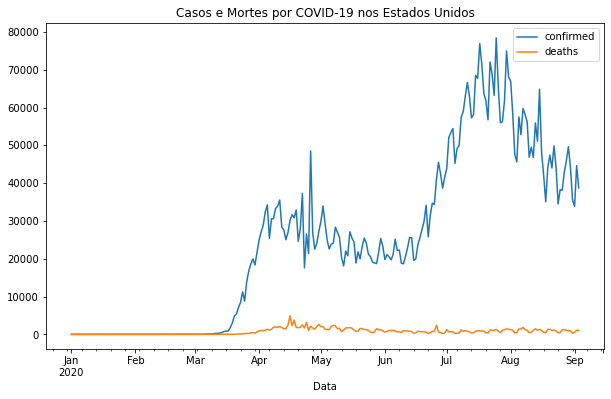

In [8]:
# Plotando o número de casos confirmados e mortes
title = 'Casos e Mortes por COVID-19 nos Estados Unidos'
ylabel = ''
xlabel = 'Data'

ax=df.plot(title=title,figsize=(10,6))
ax.autoscale(axis='both')
ax.set(xlabel=xlabel,ylabel=ylabel)
plt.show()


In [9]:
# Exibindo medidas descritivas da série de mortes
df['deaths'].describe()

count     247.000000
mean      752.000000
std       768.724934
min         0.000000
25%         1.000000
50%       661.000000
75%      1180.500000
max      4928.000000
Name: deaths, dtype: float64

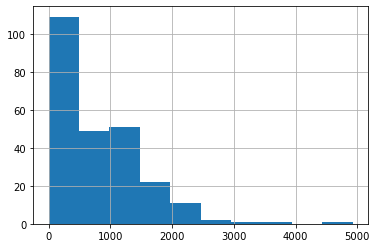

In [10]:
# Plotando um histograma do número de mortes
df['deaths'].hist(bins=10);

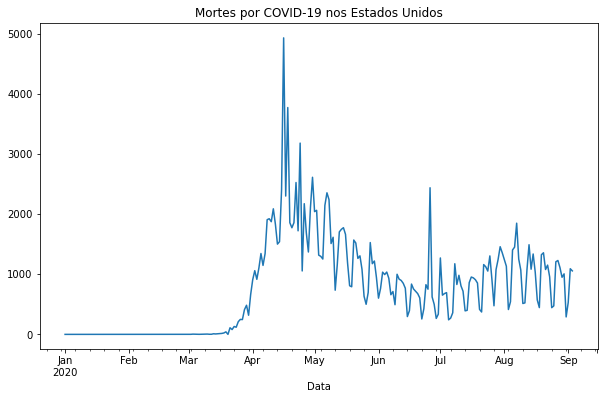

In [11]:
# Plotando com um gráfico de linha os valores de mortes observadas
deaths = df['deaths']

title = 'Mortes por COVID-19 nos Estados Unidos'
ylabel = ''
xlabel = 'Data'

ax=deaths.plot(title=title,figsize=(10,6))
ax.autoscale(axis='both')
ax.set(xlabel=xlabel,ylabel=ylabel)
plt.show()

In [12]:
# Verificando quantas observações de número de mortes possui valores iguais a 0
z = np.array(df['deaths'])
num_zeros = (z == 0).sum()
num_non_zeros = (z > 0).sum()
print('Registros de mortes zerados: ', num_zeros)
print('Registros de mortes não zerados: ', num_non_zeros)

Registros de mortes zerados:  61
Registros de mortes não zerados:  186


In [13]:
# verificando os valores de morte que são iguais a 0
df_zero = df.query('deaths == 0')
df_zero.tail(10)

,confirmed,deaths
date,,
2020-02-21,1,0
2020-02-22,19,0
2020-02-23,0,0
2020-02-24,0,0
2020-02-25,18,0
2020-02-26,0,0
2020-02-27,6,0
2020-02-28,1,0
2020-02-29,6,0


In [14]:
# verificando os valores de morte que são diferentes a 0
df_non_zero = df.query('deaths > 0')
df_non_zero.head(20)

,confirmed,deaths
date,,
2020-03-01,3,1
2020-03-02,20,1
2020-03-03,14,4
2020-03-04,22,3
2020-03-05,34,2
2020-03-06,74,1
2020-03-07,105,2
2020-03-08,95,3
2020-03-09,121,4


<font color='darkred'>
As mortes começaram a acontecer a partir do dia 01/03/20 quando houve o registro de 1 morte confirmada. Porém no dia 20/03/20 o registro de mortes está zerado, e isso é um problema para realizar as previsões.
    

Seguindo as recomendações da Profª Cibele, vou inputar um valor pequeno (1) para conseguir fazer as previsões utilizando Holt-Holt Winters, de forma que esse valor não tenha peso para impactar muito no resultado final. Além disso, irei subtrair esse valor do dia seguinte 21/03/20, pois provavelmente as mortes do dia anterior estão computadas nesse índice.
</font>

In [15]:
# acessando os valores da observação problemática
print(' Valores antes da alteração')
print(' Índice:',df.index[79],'\n','Casos:',df['confirmed'][79],'\n','Mortes:',df['deaths'][79],'\n')

print(' Índice:',df.index[80],'\n','Casos:',df['confirmed'][80],'\n','Mortes:',df['deaths'][80])

 Valores antes da alteração
 Índice: 2020-03-20 00:00:00 
 Casos: 4835 
 Mortes: 0 

 Índice: 2020-03-21 00:00:00 
 Casos: 5374 
 Mortes: 110


In [16]:
# Fazendo as alterações nos valores dos índices 
df['deaths'][79] = 1
df['deaths'][80] = df['deaths'][80] - df['deaths'][79]

# Acessando os valores corrigidos
print(' Valores depois da alteração')
print(' Índice:',df.index[79],'\n','Casos:',df['confirmed'][79],'\n','Mortes:',df['deaths'][79],'\n')
print(' Índice:',df.index[80],'\n','Casos:',df['confirmed'][80],'\n','Mortes:',df['deaths'][80])

 Valores depois da alteração
 Índice: 2020-03-20 00:00:00 
 Casos: 4835 
 Mortes: 1 

 Índice: 2020-03-21 00:00:00 
 Casos: 5374 
 Mortes: 109


<font color='darkred'>
Os dados foram importados com sucesso e nesse caso, não houve problema de dados faltantes.

As únicas alterações realizadas foram:

* Definição de frequência do DatatimeIndex para valores diários com a frequência 'D'
* Acréscimo de valor (1) ao número de mortes no índice 79 
* Decréscimo de valor (1) ao número de mortes no índice 80 

### 2) Proponha uma decomposição dos dados de mortes em tendência e sazonalidade. Obtenha os gráficos de autocorrelação e autocorrelação parcial. Comente brevemente os resultados.

<font color='darkred'>
    Realizando a decomposição dos dados em tendência e sazonalidade.
</font>

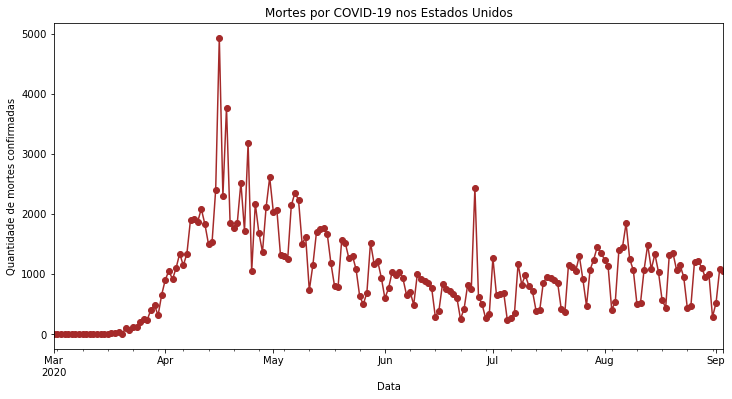

In [17]:
# Visualizando o número de mortes

# Para conseguir decompor a série corretamente e realizar previsões, vou utilizar apenas os dados cujos valores são >0
deaths = df['deaths'][df['deaths']>0]
deaths.plot(title='Mortes por COVID-19 nos Estados Unidos',
            figsize=(12,6), 
            xlabel='Data',
            ylabel='Quantidade de mortes confirmadas',
            marker='o',
            linestyle='solid',
            color='brown')
plt.show()

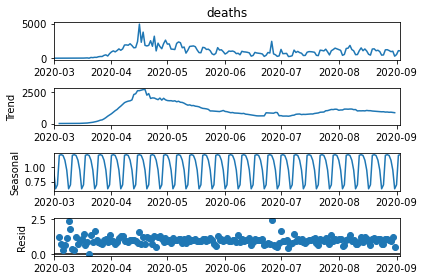

In [18]:
# Decomposição multiplicativa
result1 = seasonal_decompose(deaths, model='multiplicative', period=7)
fig = result1.plot()

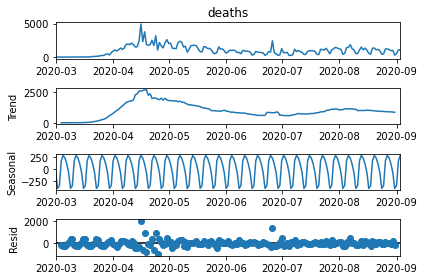

In [19]:
# Decomposição aditiva
result2 = seasonal_decompose(deaths, model='additive', period=7)
fig = result2.plot()

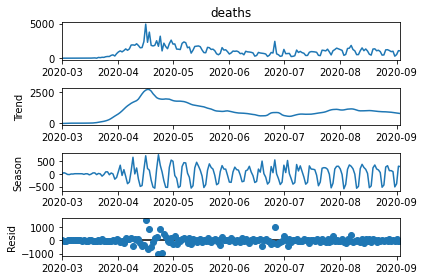

In [20]:
# Utilizando um outro método para decomposição de tendência e sazonalidade usando o método Seasonal-Trend with LOESS
stl = STL(deaths)
result2 = stl.fit()
fig = result2.plot()

<font color='darkred'>
Olhando para os resíduos de todas as decomposições, é possível notar que os resíduos apresentam alguns pontos que com comportamento atípico (outliers).
    
Apesar de não ter visto exemplos desse método em aula, resolvi aplicar uma decomposição usando o método de decomposição 'Seasonal-Trend decomposition with LOESS'. ¹
    
Devido à natureza dos dados que quero prever nessa série, creio que a decomposição multiplicativa seja mais adequada a esse conjunto de dados. De acordo com Ehlers (2009), um modelo multiplicativo deve ser utilizado quando "O tamanho das flutuações sazonais varia dependendo do nível global da série.".²   
</font>

In [21]:
# Função para cálculo da autocorrelação da série
acf(df['deaths'])

array([ 1.        ,  0.81025844,  0.77296464,  0.68521012,  0.67798876,
        0.70972559,  0.79326238,  0.78402255,  0.77580733,  0.63277951,
        0.60024972,  0.57385254,  0.59190369,  0.63835187,  0.67409113,
        0.58912566,  0.51778883,  0.42467255,  0.42182943,  0.42607002,
        0.47535477,  0.49234394,  0.43617157,  0.33405377,  0.28857473,
        0.24587628,  0.27253782,  0.30844321,  0.32557167,  0.28171102,
        0.19077799,  0.13279359,  0.12588143,  0.11706352,  0.16880805,
        0.17420254,  0.13168014,  0.07002009,  0.0097142 , -0.01092274,
        0.00574816])

In [22]:
# Função para cálculo da autocorrelação parcial da série
pacf(df['deaths'])

array([ 1.        ,  0.81355218,  0.34722273, -0.00906976,  0.17367388,
        0.31711059,  0.44631491,  0.12857261,  0.07287996, -0.39052701,
       -0.14376775,  0.00533693, -0.114789  , -0.01557317,  0.12534034,
       -0.11150865, -0.20088319, -0.14892069, -0.00453419, -0.05719795,
        0.03602733,  0.11995097, -0.05918975, -0.07944632,  0.04113176,
       -0.02763027, -0.04014107,  0.06030459,  0.0577433 ,  0.03217233,
       -0.06380262,  0.0093241 ,  0.0546175 , -0.08596765, -0.03278356,
       -0.05465769, -0.02768483,  0.05812853, -0.02248832, -0.0702418 ,
       -0.04707488])

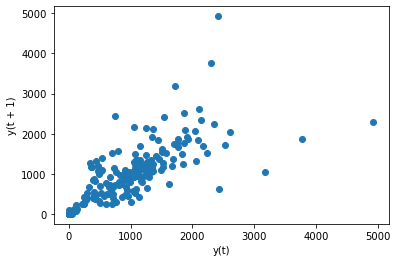

In [23]:
# Analisando a autocorrelação - lag 1 de diferença entre as séries
lag_plot(df['deaths']);

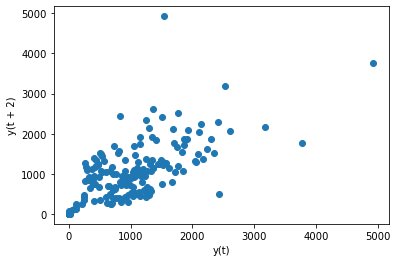

In [24]:
# Analisando a autocorrelação - lag 2 de diferença entre as séries
lag_plot(df['deaths'], lag=2);

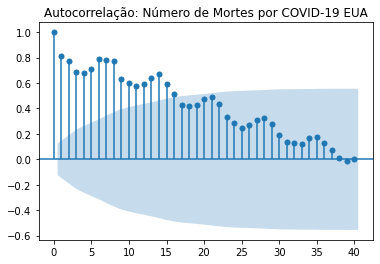

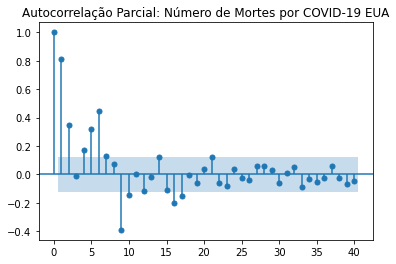

In [25]:
# Correlogramas

# Analisando a autocorrelação - lag 40
title = 'Autocorrelação: Número de Mortes por COVID-19 EUA'
lags = 40
plot_acf(df['deaths'],title=title,lags=lags);

# Analisando a autocorrelação parcial - lag 40
title = 'Autocorrelação Parcial: Número de Mortes por COVID-19 EUA'
lags = 40
plot_pacf(df['deaths'],title=title,lags=lags);

<font color='darkred'>
    Com base nessas análises, é possível associar essa série a uma série não-estacionária, com indícios de sazonalidade e tendência, além de autocorrelação entre suas séries.
</font>

### 3) Divida a base em treino e teste, com 21 observações na base de teste. Você deverá apresentar em distintas colunas na mesma base de dados que será entregue:

* Os dados originais de casos confirmados e mortes.
* As previsões de Holt e Holt Winters para a variável mortes.
* As previsões obtidas pelo melhor modelo SARIMA, com ordens selecionadas segundo critério preestabelecido para a variável mortes. Identifique as componentes desse melhor modelo (por exemplo, “o modelo tem uma componente autorregressiva não sazonal de ordem .., uma componente de médias móveis não-sazonal de ordem.., etc).
* As previsões obtidas por um modelo de redes dinâmicas para a variável mortes.

#### 3.2) As previsões de Holt e Holt Winters para a variável mortes.

<font color='darkred'>
    
### Métodos Holt e Holt-Winters (Treino)

In [26]:
# Definindo e separando as bases de treino e teste
train = df['deaths'].iloc[:226].astype('float') 
test = df['deaths'].iloc[226:].astype('float') 

print('Total de linhas da base de treino: ', train.shape[0],'\n')
print('Total de linhas da base de teste: ', test.shape[0])

Total de linhas da base de treino:  226 

Total de linhas da base de teste:  21


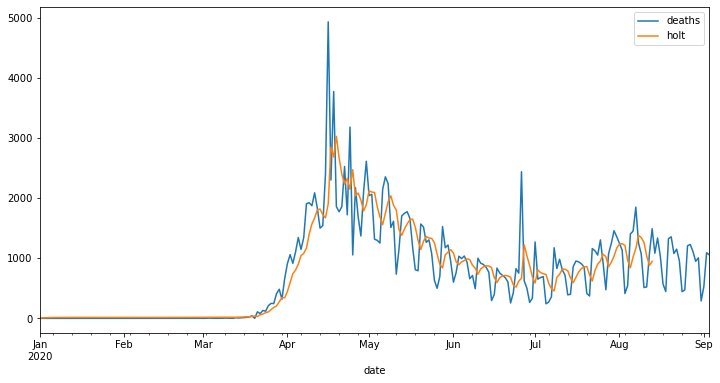

In [27]:
# Previsão de Holt com tendência aditiva
model_holt =  ExponentialSmoothing(train, trend='add')
fit_model = model_holt.fit()

df['holt'] = fit_model.fittedvalues

# Visualizando os resultados do modelo Holt
df[['deaths','holt']].plot(figsize=(12,6)).autoscale(axis='x',tight=True)

<font color='darkred'>
    No caso desse método, parece que a previsão não acompanhou muito bem os picos e os vales da série de treino, o que pode indicar que a utilização do método Holt-Winters com o parâmetro de sazonalidade parece ser mais apropriado.
</font>

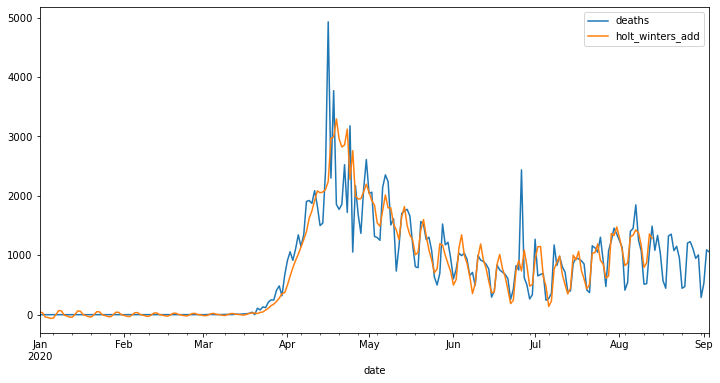

In [28]:
# Ajuste do modelo pelo Método de Holt-Winters com sazonalidade aditiva
model_h_w_add =  ExponentialSmoothing(train,trend='add',seasonal='add',seasonal_periods=7)

fit_model = model_h_w_add.fit()

df['holt_winters_add'] = fit_model.fittedvalues

# Visualizando os resultados do modelo Holt-Winters aditivo
df[['deaths','holt_winters_add']].plot(figsize=(12,6)).autoscale(axis='x',tight=True)

<font color='darkred'>
    A previsão de Holt-Winters, mesmo com sazonalidade aditiva que parece não ser tão adequada a esse tipo de série já demonstrou comportamento superior em relação aos valores ajustados com Holt. O modelo ajustado claramente já está acompanhando mais a sazonalidade, apesar de ainda ter alguns problemas em detectar os maiores picos e vales.
</font>

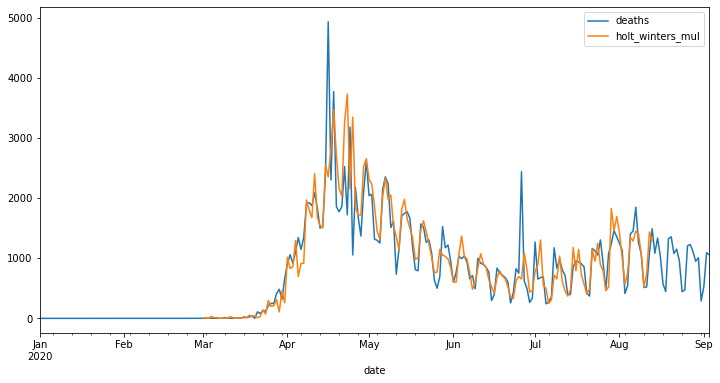

In [29]:
# Prevendo os valoes da série de teste com Holt-Winters com sazonalidade multiplicativa
model_h_w_mul =  ExponentialSmoothing(train.iloc[60:],trend='add',seasonal='mul',seasonal_periods=7)
fit_model = model_h_w_mul.fit()

df['holt_winters_mul'] = fit_model.fittedvalues

# Visualizando os resultados do modelo Holt-Winters aditivo
df[['deaths','holt_winters_mul']].plot(figsize=(12,6)).autoscale(axis='x',tight=True)

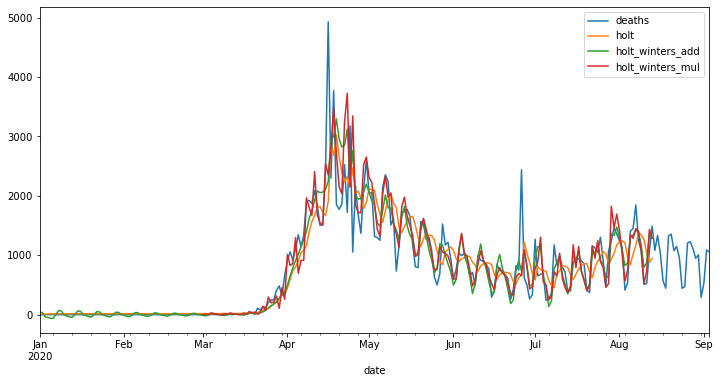

In [30]:
# Visualizando todas os resultados dos modelos Holt e Holt-Winters ajustados
df[['deaths','holt','holt_winters_add','holt_winters_mul']].plot(figsize=(12,6)).autoscale(axis='x',tight=True)

<font color='darkred'>
    Alterando a configuração para a sazonalidade multiplicativa parece ter ajustado o melhor modelo dentre os últimos, acompanhando bem melhor a sazonalidade da série. Agora, vamos ver como esse métodos se saem para prever os valores da série de teste.
</font>

<font color='darkred'>
    
### Métodos Holt e Holt-Winters (Teste)

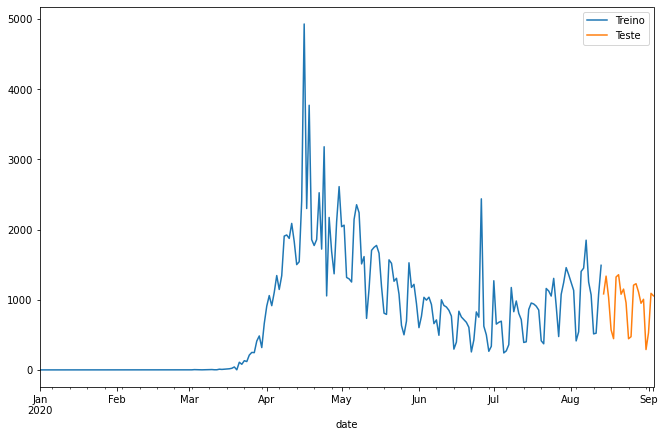

In [31]:
# Visualizando os dados de treino e teste
train.plot(legend=True,label='Treino')
test.plot(legend=True,label='Teste',figsize=(11,7));

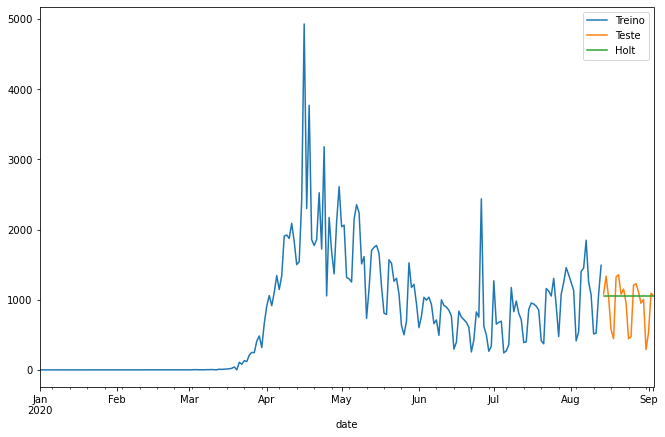

In [32]:
# Prevendo os valoes da série de teste com Holt tendência aditiva
model_holt = ExponentialSmoothing(test, trend='add').fit()
pred_holt = model_holt.forecast(21)

pred_holt.index = df.index[226:]
df['holt'].iloc[226:] = pred_holt

# Visualizando os resultados do modelo
train.plot(legend=True,label='Treino')
test.plot(legend=True,label='Teste')
pred_holt.plot(legend=True,label='Holt',figsize=(11,7));

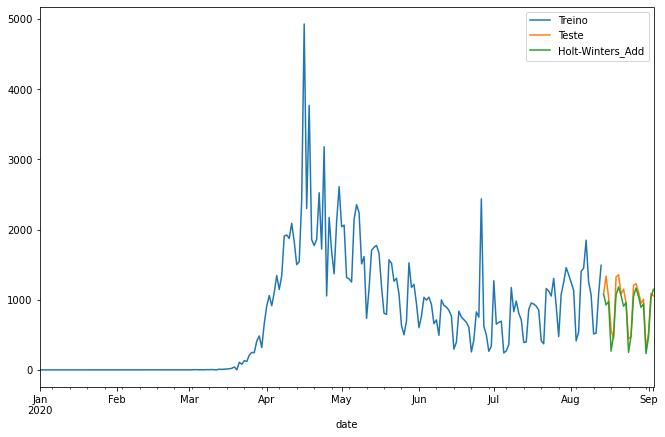

In [33]:
# Prevendo os valoes da série de teste com Holt-Winters com sazonalidade aditiva
model_h_w_add = ExponentialSmoothing(test, trend='add',seasonal='add',seasonal_periods=7).fit()
pred_h_w_add = model_h_w_add.forecast(21)

pred_h_w_add.index = df.index[226:]
df['holt_winters_add'].iloc[226:] = pred_h_w_add

# Visualizando os resultados do modelo
train.plot(legend=True,label='Treino')
test.plot(legend=True,label='Teste')
pred_h_w_add.plot(legend=True,label='Holt-Winters_Add',figsize=(11,7));

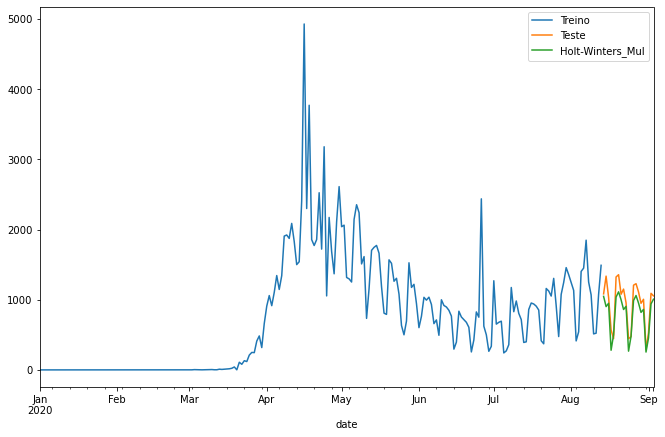

In [34]:
# Prevendo os valores da série de teste com Holt-Winters com sazonalidade multiplicativa
model_h_w_mul = ExponentialSmoothing(test, trend='add',seasonal='mul',seasonal_periods=7).fit()
pred_h_w_mul = model_h_w_mul.forecast(21)

pred_h_w_mul.index = df.index[226:]
df['holt_winters_mul'].iloc[226:] = pred_h_w_mul

# Visualizando os resultados do modelo
train.plot(legend=True,label='Treino')
test.plot(legend=True,label='Teste')
pred_h_w_mul.plot(legend=True,label='Holt-Winters_Mul',figsize=(11,7));

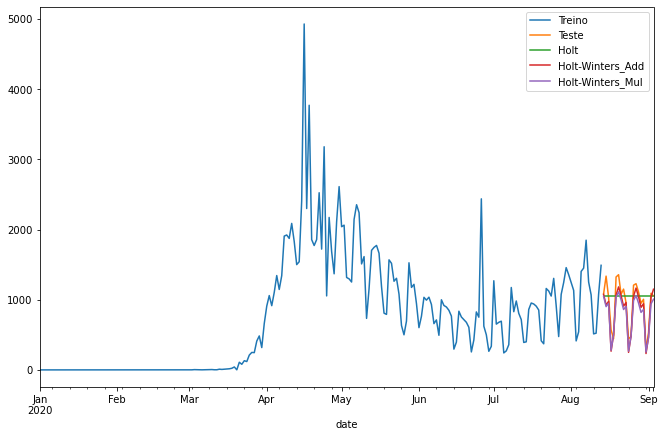

In [35]:
# Visualizando as previsões da série de teste com todos os métodos utilizados
train.plot(legend=True,label='Treino')
test.plot(legend=True,label='Teste')
pred_holt.plot(legend=True,label='Holt')
pred_h_w_add.plot(legend=True,label='Holt-Winters_Add')
pred_h_w_mul.plot(legend=True,label='Holt-Winters_Mul',figsize=(11,7));

In [36]:
# Criando um DataFrame para armazenar os resultados de MAE e MSE dos métodos utilizados
ind = 'MAE','MSE'
metrics = {'Holt':[mean_absolute_error(test,pred_holt),mean_squared_error(test,pred_holt)],
           'Holt-Winters_Add':[mean_absolute_error(test,pred_h_w_add),mean_squared_error(test,pred_h_w_add)],
           'Holt-Winters_Mul':[mean_absolute_error(test,pred_h_w_mul),mean_squared_error(test,pred_h_w_mul)]}
df_metrics = pd.DataFrame(data=metrics)
df_metrics.index = ind
df_metrics.head()

,Holt,Holt-Winters_Add,Holt-Winters_Mul
MAE,250.761905,114.942352,150.597770
MSE,119711.714286,24854.915906,34348.231096


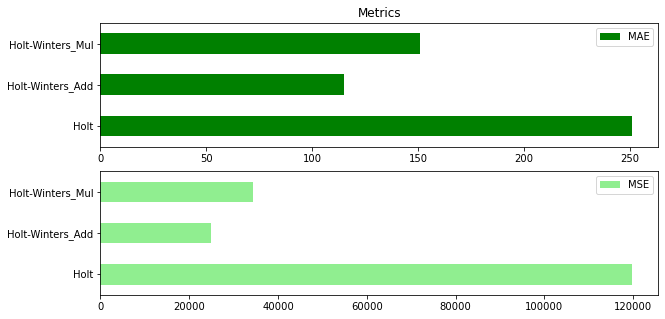

In [37]:
# Plotando os resultados das métricas de avaliação
plt.figure(1)
plt.subplot(211)
df_metrics.loc['MAE'].plot(kind='barh', color='green', title='Metrics', legend=True)

plt.subplot(212)
df_metrics.loc['MSE'].plot(kind='barh', color='lightgreen', legend=True, figsize=(10,5))

plt.show()

<font color='darkred'>
    Interessante que mesmo com uma indicação mais propensa à utilização do método de sazonalidade multiplicativa, o método que apresentou menor erro em relação às previsões da base de treino foi o Holt-Winters com sazonalidade aditiva. Provavelmente isso ocorreu nessa série pela grande quantidade de zeros, conforme informado pela Profª Cibele em uma das aulas.
</font>

#### 3.3) As previsões obtidas pelo melhor modelo SARIMA, com ordens selecionadas segundo critério preestabelecido para a variável mortes. Identifique as componentes desse melhor modelo (por exemplo, “o modelo tem uma componente autorregressiva não sazonal de ordem .., uma componente de médias móveis não-sazonal de ordem.., etc).

<font color='darkred'>
    
### Métodos SARIMA

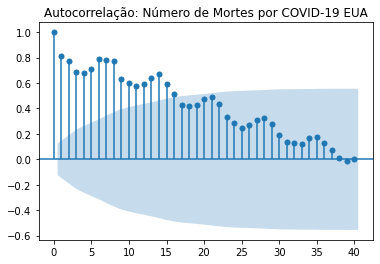

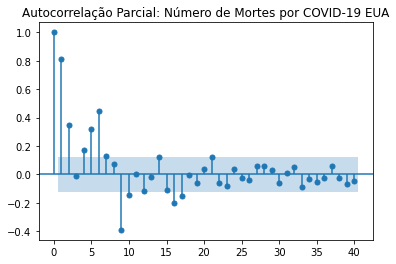

In [38]:
# Plotando novamente os correlogramas da série do número de mortes

# Autocorrelação - lag 40
title = 'Autocorrelação: Número de Mortes por COVID-19 EUA'
lags = 40
plot_acf(df['deaths'],title=title,lags=lags);

# Autocorrelação parcial - lag 40
title = 'Autocorrelação Parcial: Número de Mortes por COVID-19 EUA'
lags = 40
plot_pacf(df['deaths'],title=title,lags=lags);

<font color='darkred'>
Olhando os correlogramas, a série apresenta componente sazonal e alguma correlação, pelo que indicam os pontos acima do intervalo de confiança do gráfico de Autocorrelação. A Autocorrelação parcial não esclareceu muita coisa, apesar de ser nítida uma associação entre as séries 1 e 2.
    
Em todo caso, parece que faz sentido utilizar um modelo que possua componente de sazonalidade e componente auto-regressivo.    
</font>

In [39]:
# Escolha de modelo SARIMA com stepwise
np.random.seed(0)
stepwise_fit = auto_arima(df['deaths'], start_p=0, start_q=0,
                          max_p=10, max_q=8, m=7,
                          seasonal=True, trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True,
                          random_state=0)           

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=3733.996, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3729.996, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=3654.779, Time=0.57 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=3652.583, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3728.019, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=3667.602, Time=0.21 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=3596.107, Time=1.88 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=3638.859, Time=0.86 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=3592.672, Time=2.33 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=3603.515, Time=1.47 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=3600.245, Time=3.44 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=3594.062, Time=2.90 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=3688.287, Time=1.61 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=3587.434, Time=3.10 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  247
Model:             SARIMAX(3, 1, 3)x(2, 0, [1], 7)   Log Likelihood               -1775.374
Date:                             Mon, 21 Sep 2020   AIC                           3570.747
Time:                                     04:03:11   BIC                           3605.800
Sample:                                          0   HQIC                          3584.861
                                             - 247                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8537      0.060     14.181      0.000       0.736       0.972
ar.L2         -0.5033      0.076     -6.648      0.000      -0.652      -0.355
ar.L3         -0.3792      0.052     -7.281      0.000      -0.481      -0.277
ma.L1         -1.6054      0.068    -23.775      0.000      -1.738      -1.473
ma.L2          1.3688      0.094     14.533      0.000       1.184       1.553
ma.L3         -0.3849      0.062     -6.179      0.000      -0.507      -0.263
ar.S.L7        0.5014      0.348      1.442      0.149      -0.180       1.183
ar.S.L14       0.1675      0.092      1.815      0.069      -0.013       0.348
ma.S.L7       -0.5180      0.340     -1.525      0.127      -1.184       0.148
sigma2      1.093e+05   3953.937     27.643      0.000    1.02e+05    1.17e+05
===================================================================================
Ljung-Box (Q):                       44.28   Jarque-Bera (JB):              7562.03
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):             516.90   Skew:                             2.79
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<font color='darkred'>
De acordo com o ajuste via stepwise, e utilizando como critério o AIC, o melhor modelo encontrado foi um modelo com componente não sazonal auto-regressiva de ordem 3, com componente integrado não sazonal de ordem 1, e componente de média móvel não sazonal de ordem 3.

Além disso, o modelo possui componentes sazonal auto-regressivas de ordem 2, e componente sazonal de médias móveis de ordem 1, para o período = 7.

Portanto, melhor modelo ajustado foi o SARIMAX(3, 1, 3)x(2, 0, [1], 7), com AIC de 3570.747.
    
Outra informação relevante é a alta variância observada para o ruído da série, representada pelo sigma2. 
    
Por fim, olhando para o p-value, todos as componentes auto-regressivas e de médias móveis não sazonais apresentaram coeficientes significantes, enquanto os mesmos componentes sazonais não.
    
</font>

In [40]:
# Utilizando o melhor método indicado na base de treino
model_sarimax_train = SARIMAX(train,simple_differencing=True,order=(3,1,3),seasonal_order=(2,1,0,7))
results_train = model_sarimax_train.fit()
results_train.summary()

c:\users\2104411064\anaconda3\envs\ad_env_v2\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       D.DS7.deaths   No. Observations:                  218
Model:             SARIMAX(3, 0, 3)x(2, 0, [], 7)   Log Likelihood               -1590.678
Date:                            Mon, 21 Sep 2020   AIC                           3199.356
Time:                                    04:03:15   BIC                           3229.816
Sample:                                01-09-2020   HQIC                          3211.659
                                     - 08-13-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.1981      0.060    -36.488      0.000      -2.316      -2.080
ar.L2         -1.8163      0.111    -16.359      0.000      -2.034      -1.599
ar.L3         -0.5406      0.060     -9.031      0.000      -0.658      -0.423
ma.L1          1.4851      0.073     20.223      0.000       1.341       1.629
ma.L2          0.4646      0.125      3.711      0.000       0.219       0.710
ma.L3         -0.2829      0.072     -3.948      0.000      -0.423      -0.142
ar.S.L7       -0.6028      0.055    -11.001      0.000      -0.710      -0.495
ar.S.L14      -0.2194      0.073     -2.995      0.003      -0.363      -0.076
sigma2       1.23e+05   4049.080     30.388      0.000    1.15e+05    1.31e+05
===================================================================================
Ljung-Box (Q):                       34.39   Jarque-Bera (JB):              4408.22
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):            1004.68   Skew:                             1.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
# Utilizando o melhor método indicado na base de teste
model_sarimax_test = SARIMAX(test,simple_differencing=True,order=(3,1,3),seasonal_order=(2,1,0,7))
results_test = model_sarimax_test.fit()
results_test.summary()

c:\users\2104411064\anaconda3\envs\ad_env_v2\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       D.DS7.deaths   No. Observations:                   13
Model:             SARIMAX(3, 0, 3)x(2, 0, [], 7)   Log Likelihood                 -71.379
Date:                            Mon, 21 Sep 2020   AIC                            160.758
Time:                                    04:03:17   BIC                            165.843
Sample:                                08-22-2020   HQIC                           159.713
                                     - 09-03-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3816      2.384     -0.160      0.873      -5.053       4.290
ar.L2         -0.2222      3.649     -0.061      0.951      -7.375       6.930
ar.L3          0.1174      2.652      0.044      0.965      -5.081       5.316
ma.L1         -1.1229    164.524     -0.007      0.995    -323.583     321.337
ma.L2          1.0351     10.230      0.101      0.919     -19.014      21.085
ma.L3         -0.9070    125.917     -0.007      0.994    -247.699     245.885
ar.S.L7        0.0069      3.187      0.002      0.998      -6.240       6.254
ar.S.L14       0.9910      4.168      0.238      0.812      -7.179       9.161
sigma2        33.3173   2.02e+04      0.002      0.999   -3.96e+04    3.97e+04
===================================================================================
Ljung-Box (Q):                       13.48   Jarque-Bera (JB):                 0.72
Prob(Q):                              0.34   Prob(JB):                         0.70
Heteroskedasticity (H):               0.46   Skew:                             0.55
Prob(H) (two-sided):                  0.47   Kurtosis:                         2.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

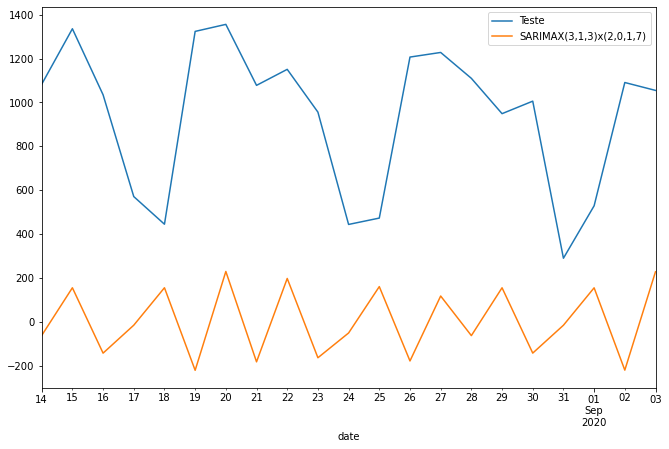

In [49]:
# Obtendo as previsões e comparando com os dados originais

# Base de teste
start = len(train)
end = len(train) + len(test) -1
pred_sarimax = results_test.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMAX(3,1,3)x(2,0,1,7)')
pred_sarimax.index = test.index

# Visualizando as previsões da série de teste
test.plot(legend=True,label='Teste')
pred_sarimax.plot(legend=True,label='SARIMAX(3,1,3)x(2,0,1,7)',figsize=(11,7));

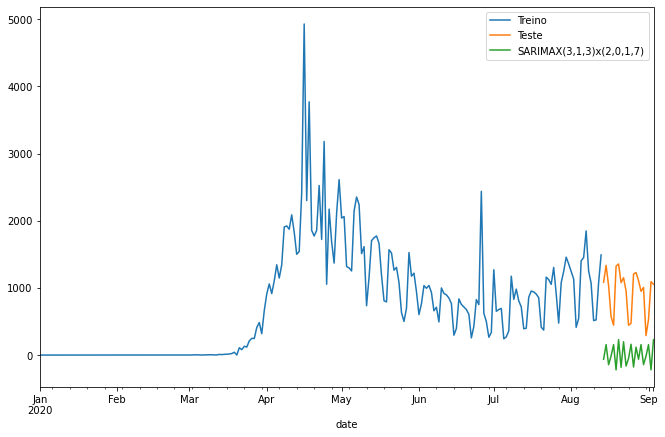

In [50]:
# Visualizando as previsões da série de treino e teste
train.plot(legend=True,label='Treino')
test.plot(legend=True,label='Teste')
pred_sarimax.plot(legend=True,label='SARIMAX(3,1,3)x(2,0,1,7)',figsize=(11,7));

<font color='darkred'>
Como o ajuste do modelo indicado SARIMAX(3,1,3)x(2,0,1,7) não ofereceu um bom ajuste ao conjunto de dados de teste, resolvi por conta fazer um teste com um outro modelo, dessa vez sem componente sazonal.


A escolha também foi feita via stepwise, que retornou que o melhor modelo seria o ARIMA(5,1,3), ou seja, como componentes não sazonais auto-regressivas de ordem 5, componente integrada de ordem 1, e componente de médias móveis de ordem 3. Seguem os resultados encontrados.

In [51]:
# Utilizando o melhor método indicado na base de teste
model_arima_test = SARIMAX(test,simple_differencing=True,order=(5,1,3))
results_test_arima = model_arima_test.fit()
results_test_arima.summary()

c:\users\2104411064\anaconda3\envs\ad_env_v2\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               D.deaths   No. Observations:                   20
Model:               SARIMAX(5, 0, 3)   Log Likelihood                -135.953
Date:                Mon, 21 Sep 2020   AIC                            289.906
Time:                        04:06:14   BIC                            298.867
Sample:                    08-15-2020   HQIC                           291.655
                         - 09-03-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2516      0.028     -8.945      0.000      -0.307      -0.197
ar.L2         -0.6535      0.027    -24.449      0.000      -0.706      -0.601
ar.L3         -0.6511      0.033    -19.938      0.000      -0.715      -0.587
ar.L4         -0.2590      0.029     -8.836      0.000      -0.316      -0.202
ar.L5         -0.9886      0.017    -57.587      0.000      -1.022      -0.955
ma.L1         -0.7734      0.463     -1.672      0.095      -1.680       0.133
ma.L2          1.0594      1.774      0.597      0.550      -2.418       4.536
ma.L3         -0.1804      0.391     -0.461      0.645      -0.947       0.586
sigma2      3086.4445   5298.111      0.583      0.560   -7297.662    1.35e+04
===================================================================================
Ljung-Box (Q):                       18.13   Jarque-Bera (JB):                 0.92
Prob(Q):                              0.51   Prob(JB):                         0.63
Heteroskedasticity (H):               2.52   Skew:                            -0.52
Prob(H) (two-sided):                  0.25   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
# Base de teste
start = len(train)
end = len(train) + len(test) -1
pred_arima = results_test_arima.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(5,0,3)')
pred_arima.index = test.index

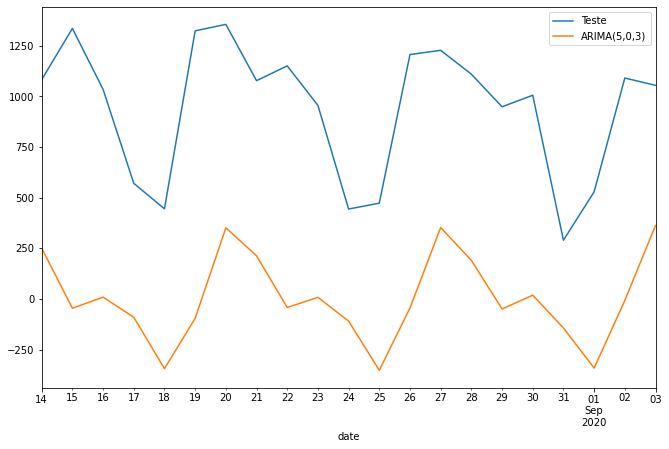

In [53]:
# Visualizando as previsões da série de teste
test.plot(legend=True,label='Teste')
pred_arima.plot(legend=True,label='ARIMA(5,0,3)',figsize=(11,7));

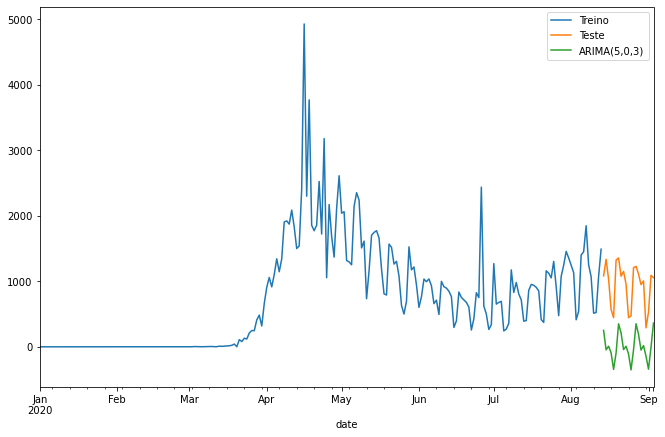

In [54]:
# Visualizando as previsões da série de treino e teste
train.plot(legend=True,label='Treino')
test.plot(legend=True,label='Teste')
pred_arima.plot(legend=True,label='ARIMA(5,0,3)',figsize=(11,7));

In [55]:
# Criando as previsões do número de mortes com o ARIMA(3,1,3) e incorporando no dataset original
df['ARIMA(5,0,3)'] = ''
df['ARIMA(5,0,3)'].iloc[226:] = pred_arima

df.tail()

,confirmed,deaths,holt,holt_winters_add,holt_winters_mul,"ARIMA(5,0,3)"
date,,,,,,
2020-08-30,44143,1006,1055.0,943.223756,861.919998,18.4922
2020-08-31,35581,290,1055.0,233.512970,254.113271,-143.388
2020-09-01,33850,529,1055.0,467.565904,455.804293,-341.673
2020-09-02,44639,1091,1055.0,1033.897269,940.048518,-7.81831
2020-09-03,38754,1055,1055.0,1149.341461,1007.333550,362.811


In [56]:
# Criando as previsões do número de mortes com o SARIMAX(3,1,3)x(2,0,1,7)) e incorporando no dataset original
df['SARIMAX(3,1,3)x(2,0,1,7)'] = ''
df['SARIMAX(3,1,3)x(2,0,1,7)'].iloc[226:] = pred_sarimax

df.tail()

,confirmed,deaths,holt,holt_winters_add,holt_winters_mul,"ARIMA(5,0,3)","SARIMAX(3,1,3)x(2,0,1,7)"
date,,,,,,,
2020-08-30,44143,1006,1055.0,943.223756,861.919998,18.4922,-142.481
2020-08-31,35581,290,1055.0,233.512970,254.113271,-143.388,-15.4547
2020-09-01,33850,529,1055.0,467.565904,455.804293,-341.673,155.108
2020-09-02,44639,1091,1055.0,1033.897269,940.048518,-7.81831,-220.144
2020-09-03,38754,1055,1055.0,1149.341461,1007.333550,362.811,228.423


In [57]:
df.shape

(247, 7)

#### 3.4) As previsões obtidas por um modelo de redes dinâmicas para a variável mortes.

In [58]:
# Criando o dataframe da base de teste
df_train = pd.DataFrame(data=train)
df_train.columns = ['deaths']
df_train

,deaths
date,
2020-01-01,0.0
2020-01-02,0.0
2020-01-03,0.0
2020-01-04,0.0
2020-01-05,0.0
...,...
2020-08-09,1069.0
2020-08-10,513.0
2020-08-11,523.0


In [59]:
# Criando o dataframe da base de teste
df_test = pd.DataFrame(data=test)
df_test.columns = ['deaths']
df_test

,deaths
date,
2020-08-14,1083.0
2020-08-15,1336.0
2020-08-16,1035.0
2020-08-17,571.0
2020-08-18,445.0
2020-08-19,1324.0
2020-08-20,1356.0
2020-08-21,1078.0
2020-08-22,1151.0


In [60]:
# Definindo o padronizador dos meus dados e ajustando a base de treino
print('Padronizando base de treino...')
scaler = MinMaxScaler()
scaler.fit(df_train)
print('Ok')

Padronizando base de treino...
Ok


In [61]:
scaled_train = scaler.transform(df_train)
print("Valores min e max da base de treino transformada")
print("Min: ",scaled_train.min(),"Max: ",scaled_train.max())
print("\n")
scaled_test = scaler.transform(df_test)
print("Valores min e max da base de teste transformada")
print("Min: ",scaled_test.min(),"Max: ",scaled_test.max())

Valores min e max da base de treino transformada
Min:  0.0 Max:  1.0


Valores min e max da base de teste transformada
Min:  0.0588474025974026 Max:  0.27516233766233766


(array([105.,  45.,  38.,  22.,  11.,   2.,   1.,   1.,   0.,   1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

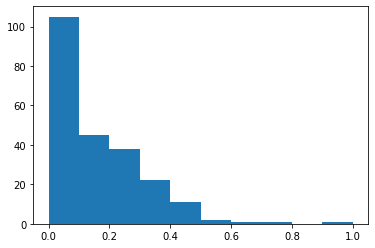

In [62]:
# Histograma da base de treino transformada
plt.hist(scaled_train)

In [63]:
# Definindo configurações para a criação da rede neural que será utilizada
# Nesse caso a rede terá 100 neurônios, e uma única saída. A função de ativação será a Relu, e a função de perda será a Mean Squared Error
n_input = 7
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [64]:
# Fit do modelo na base de treino
model.fit_generator(generator,epochs=100)

Epoch 1/100
219/219 [==============================] - 10s 47ms/step - loss: 0.0120
Epoch 2/100
219/219 [==============================] - 10s 46ms/step - loss: 0.0083
Epoch 3/100
219/219 [==============================] - 11s 48ms/step - loss: 0.0077
Epoch 4/100
219/219 [==============================] - 11s 49ms/step - loss: 0.0080
Epoch 5/100
219/219 [==============================] - 11s 50ms/step - loss: 0.0079
Epoch 6/100
219/219 [==============================] - 11s 50ms/step - loss: 0.0075
Epoch 7/100
219/219 [==============================] - 11s 51ms/step - loss: 0.0076
Epoch 8/100
219/219 [==============================] - 11s 49ms/step - loss: 0.0081
Epoch 9/100
219/219 [==============================] - 10s 47ms/step - loss: 0.0076 1s 
Epoch 10/100
219/219 [==============================] - 11s 48ms/step - loss: 0.0076
Epoch 11/100
219/219 [==============================] - 11s 50ms/step - loss: 0.0074
Epoch 12/100
219/219 [==============================] - 11s 48ms/step 

In [65]:
model.history.history.keys()

dict_keys(['loss'])

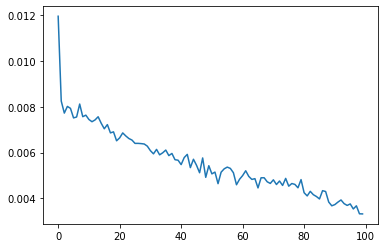

In [66]:
# Plotando o comportamento de perda por época
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);

<font color='darkred'>
O gráfico mostra que a função de perda parece se comportar como o esperado e vai caindo ao longo das iterações na base de treino.

In [67]:
# Avaliação da performance da rede com os dados de teste com 3 lotes contendo 7 observações cada
first_eval_batch = scaled_train[-7:]
first_eval_batch

array([[0.375     ],
       [0.25405844],
       [0.2169237 ],
       [0.10409903],
       [0.10612825],
       [0.21834416],
       [0.3023539 ]])

In [68]:
# Ajustando as previsões para o primeiro lote de treino
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
model.predict(first_eval_batch)

array([[0.27498537]], dtype=float32)

In [69]:
# Ajustando as predições para 
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
current_batch.shape

(1, 7, 1)

In [70]:
# Aplicando a rede neural treinada para o restante da base de teste
print('Fitando a rede para a base de teste...')

np.append(current_batch[:,1:,:],[[[99]]],axis=1)
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

print('Ok')

Fitando a rede para a base de teste...
Ok


In [71]:
print('Pred test: ',test_predictions)

print('Scaled test: ', scaled_test)

Pred test:  [array([0.27498537], dtype=float32), array([0.24361524], dtype=float32), array([0.18843617], dtype=float32), array([0.09701404], dtype=float32), array([0.0901502], dtype=float32), array([0.20488016], dtype=float32), array([0.295596], dtype=float32), array([0.26081368], dtype=float32), array([0.22220686], dtype=float32), array([0.1739206], dtype=float32), array([0.09005042], dtype=float32), array([0.08801453], dtype=float32), array([0.19821842], dtype=float32), array([0.2801914], dtype=float32), array([0.24570799], dtype=float32), array([0.21062922], dtype=float32), array([0.16882893], dtype=float32), array([0.09025951], dtype=float32), array([0.09235953], dtype=float32), array([0.19706568], dtype=float32), array([0.26772857], dtype=float32)]
Scaled test:  [[0.21976461]
 [0.2711039 ]
 [0.21002435]
 [0.11586851]
 [0.09030032]
 [0.26866883]
 [0.27516234]
 [0.21875   ]
 [0.23356331]
 [0.19399351]
 [0.0900974 ]
 [0.09598214]
 [0.24492695]
 [0.24918831]
 [0.22524351]
 [0.19257305

In [72]:
# Retomando a escala original das predições da base de teste
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[1355.12791824],
       [1200.53590202],
       [ 928.61342335],
       [ 478.08518791],
       [ 444.26018476],
       [1009.64944363],
       [1456.69710541],
       [1285.28983116],
       [1095.03540993],
       [ 857.08072472],
       [ 443.76847792],
       [ 433.73559475],
       [ 976.82037449],
       [1380.78317833],
       [1210.84896851],
       [1037.9808197 ],
       [ 831.98898888],
       [ 444.79888868],
       [ 455.14775372],
       [ 971.13967705],
       [1319.36637878]])

In [73]:
true_predictions.shape

(21, 1)

In [74]:
true_predictions = pd.DataFrame(data=true_predictions)
true_predictions.index = test.index

In [75]:
true_predictions.columns = ['LSTM']
true_predictions

,LSTM
date,
2020-08-14,1355.127918
2020-08-15,1200.535902
2020-08-16,928.613423
2020-08-17,478.085188
2020-08-18,444.260185
2020-08-19,1009.649444
2020-08-20,1456.697105
2020-08-21,1285.289831
2020-08-22,1095.035410


In [81]:
# Incorporando as predições no dataframe original
df = pd.merge(df, true_predictions, how='left', left_index=True, right_index=True)
df.tail(20)

,confirmed,deaths,holt,holt_winters_add,holt_winters_mul,"ARIMA(5,0,3)","SARIMAX(3,1,3)x(2,0,1,7)",LSTM_x,LSTM_y
date,,,,,,,,,
2020-08-15,64838,1336,1055.0,923.956916,901.708969,-45.814,155.344,1200.535902,1200.535902
2020-08-16,48085,1035,1055.0,976.243416,949.086805,8.74001,-142.636,928.613423,928.613423
2020-08-17,42104,571,1055.0,266.532630,279.998982,-90.447,-15.2427,478.085188,478.085188
2020-08-18,35056,445,1055.0,500.585564,502.575947,-344.448,155.4,444.260185,444.260185
2020-08-19,44091,1324,1055.0,1066.916929,1037.222384,-95.6339,-220.903,1009.649444,1009.649444
2020-08-20,47426,1356,1055.0,1182.361121,1112.237319,351.079,229.677,1456.697105,1456.697105
2020-08-21,44005,1078,1055.0,1060.023506,999.918026,213.198,-182.349,1285.289831,1285.289831
2020-08-22,49880,1151,1055.0,907.447086,860.571095,-42.1827,197.766,1095.035410,1095.035410
2020-08-23,44378,956,1055.0,959.733586,905.503401,8.01509,-163.675,857.080725,857.080725


In [86]:
# Salvando a rede criada
model.save('rnn_lstm.h5')
print('Ok')

Ok


### 4) Utilize o erro quadrático médio e erro absoluto médio para comparar as previsões obtidas com as observações da base de teste.

In [84]:
# Criando um DataFrame para armazenar os resultados de MAE e MSE dos métodos utilizados
ind = 'MAE','MSE'
metrics = {'Holt':[mean_absolute_error(test,pred_holt),mean_squared_error(test,pred_holt)],
           'Holt-Winters_Add':[mean_absolute_error(test,pred_h_w_add),mean_squared_error(test,pred_h_w_add)],
           'Holt-Winters_Mul':[mean_absolute_error(test,pred_h_w_mul),mean_squared_error(test,pred_h_w_mul)],
           'ARIMA(5,1,3)':[mean_absolute_error(test,pred_arima),mean_squared_error(test,pred_arima)],
           'SARIMAX(3,1,3)x(2,0,1,7)':[mean_absolute_error(test,pred_sarimax),mean_squared_error(test,pred_sarimax)],
           'LSTM':[mean_absolute_error(test,true_predictions),mean_squared_error(test,true_predictions)]}
df_metrics = pd.DataFrame(data=metrics)
df_metrics.index = ind
df_metrics.head()

,Holt,Holt-Winters_Add,Holt-Winters_Mul,"ARIMA(5,1,3)","SARIMAX(3,1,3)x(2,0,1,7)",LSTM
MAE,250.761905,114.942352,150.597770,934.712446,9.342085e+02,132.572950
MSE,119711.714286,24854.915906,34348.231096,932538.175743,1.018069e+06,24624.105702


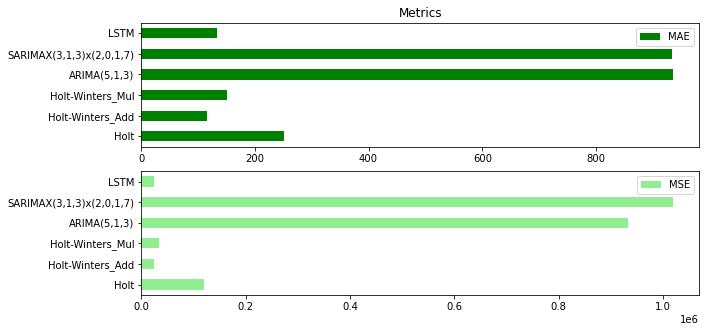

In [85]:
# Plotando os resultados das métricas de avaliação
plt.figure(1)
plt.subplot(211)
df_metrics.loc['MAE'].plot(kind='barh', color='green', title='Metrics', legend=True)

plt.subplot(212)
df_metrics.loc['MSE'].plot(kind='barh', color='lightgreen', legend=True, figsize=(10,5))

plt.show()

<font color='darkred'>
Após a comparação de todos os modelos utilizados, o Holt-Winters com tendência e sazonalidade aditivas foi o que teve menor erro (MAE/MSE).

### 5) Considere o método que produziu a melhor previsão para os dados de teste e faça a previsão para mais 14 dias (além das observações da base de dados). Essa previsão pode ser apresentada com um gráfico nos arquivos .ipynb e .pdf.

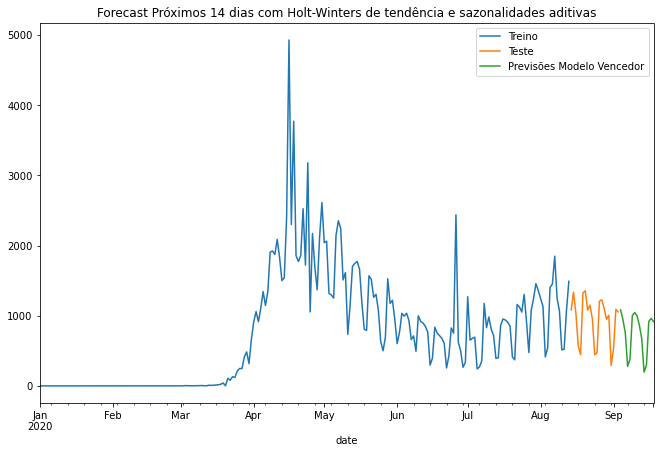

In [95]:
# Criando o forecast dos próximos dias com o modelo vencedor
modelo_vencedor = ExponentialSmoothing(df['deaths'], trend='add',seasonal='add',seasonal_periods=7)
resultados = modelo_vencedor.fit()
fcast = resultados.predict(len(df),len(df)+14).rename('Previsões Modelo Vencedor')

# Visualizando os resultados do modelo
train.plot(legend=True,label='Treino')
test.plot(legend=True,label='Teste')
fcast.plot(legend=True,label='Previsões Modelo Vencedor',figsize=(11,7),title='Forecast Próximos 14 dias com Holt-Winters de tendência e sazonalidade aditivas');

In [103]:
# Salvando o arquivo cdo dataframe original + previsões de todos os modelos
df.to_csv('df_final.csv', index=True)
print('done')

done


### Referências

**- In [20]¹: Ehlers, R.S. (2009) Análise de Séries Temporais, [http://www.icmc.usp.br/~ehlers/stemp/stemp.pdf](http://www.icmc.usp.br/~ehlers/stemp/stemp.pdf). Acessado em 16/09/2020.**

**- In [20]²: StatsmodelsSeasonal-Trend decomposition using LOESS (STL),  (https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html) . Acessado em 16/09/2020.**